In [41]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import h5py

def DL1_score(pb, pc, pl): 
    return np.log(pb/(0.08*pc + 0.92*pl))

def plot_prob_score(pb, pc, pl):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    _n, bins, _ = ax1.hist(pb, bins=50, range=(0,1), alpha=0.5, label="p_b")
    _ = ax1.hist(pc, bins=bins, alpha=0.5, label="p_c")
    _ = ax1.hist(pl, bins=bins, alpha=0.5, label="p_l")
    ax1.legend(loc="upper right")
    
    _ =ax2.hist(DL1_score(pb, pc, pl), 100, alpha=0.6)

def plot_prob_score_from_model(event,label, model):
    
    Single_Pred_prob = model(np.array(10000*[event]))
    pb = Single_Pred_prob[:,2].numpy()
    pc = Single_Pred_prob[:,1].numpy()
    pl = Single_Pred_prob[:,0].numpy()
    print("true label: ", label)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    _n, bins, _ = ax1.hist(pb, bins=50, range=(0,1),  alpha=0.5, label="p_b")
    _ = ax1.hist(pc, bins=bins,  alpha=0.5, label="p_c")
    _ = ax1.hist(pl, bins=bins,  alpha=0.5, label="p_l")
    ax1.legend(loc="upper right")
    
    _ =ax2.hist(DL1_socre(pb, pc, pl), 100,  alpha=0.6)

def efficiency(score, wp=1.0):
    return np.sum(score>wp)/len(score)

def get_mean_score(X_test, model):
    def _mean_score(inputs):
        result_prob = model(np.array(10000*[inputs]), training=False).numpy()
        result = DL1_score(result_prob[:,2], result_prob[:,1], result_prob[:,0])
        return result.mean(), result.std()

    return np.apply_along_axis(_mean_score,1, X_test)
    

    
hf = h5py.File("/Users/abletimin/cernbox/b-tagg/btagging-ml_tutorial_files/MC16d_ttbar-test-validation_sample-NN.h5", 'r')
print(hf.keys())
X_test, Y_test = hf['X_test'][:100000], hf['Y_test'][:100000]
hf.close() 
print("Total number of events: ",len(X_test) )

<KeysViewHDF5 ['X_test', 'X_trk_test', 'Y_test', 'labels', 'pt_eta']>
Total number of events:  100000


## import model


In [42]:
DL1_model = tf.keras.models.load_model("/Users/abletimin/cernbox/b-tagg/Binbin/trainTtbar/DL1r_300epoch_3000batch.h5")
#DL1_model.summary()

Pred_prob = DL1_model(X_test)

#print("true label: ", Y_test[event])
acc = tf.keras.metrics.CategoricalAccuracy()
acc.update_state(Y_test, Pred_prob.numpy())
print ("Acc: ", acc.result().numpy())

acc.update_state(Y_test[:,2], Pred_prob[:2])
print ("bjet Acc: ", acc.result().numpy())
acc.update_state(Y_test[:,1], Pred_prob[:1])
print ("cjet Acc: ", acc.result().numpy())
acc.update_state(Y_test[:,0], Pred_prob[:0])
print ("ljet Acc: ", acc.result().numpy())

Acc:  0.84721
bjet Acc:  0.84719306
cjet Acc:  0.8471846
ljet Acc:  0.8471846


In [43]:
Pred_prob_pb = Pred_prob[Y_test[:,2]==1]
efficiency( DL1_score(Pred_prob_pb[:,2], Pred_prob_pb[:,1], Pred_prob_pb[:,0]), 1.45)

<ipython-input-41-f17f6ae7bd88>:13: RuntimeWarning: overflow encountered in log
  return np.log(pb/(0.08*pc + 0.92*pl))


0.7845535737134376

In [51]:
#10 b-jets
import functools
filter_b = (Y_test[:,2]==1)
b_jets = X_test[filter_b][:10]

mean_score=get_mean_score(b_jets, functools.partial(DL1_model, training=True))

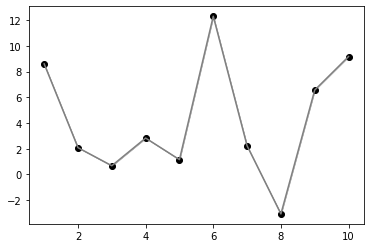

In [52]:
plt.plot(range(1,11),mean_score[:,0], "o", color="black", label="prediction" )
plt.plot(range(1,11),mean_score[:,0], "-", color="gray" )
plt.fill_between(range(1,11),mean_score[:,0]-mean_score[:,1], mean_score[:,0]+mean_score[:,1],
                 color="gray", label="prediction", alpha=0.5 )


In [53]:
mean_score

array([[ 8.6024456e+00,  1.9078254e-06],
       [ 2.0875607e+00,  2.3841858e-07],
       [ 6.8093139e-01,  5.9604645e-08],
       [ 2.8349040e+00,  4.7683716e-07],
       [ 1.1569463e+00,  1.1920929e-07],
       [ 1.2308470e+01,  1.9073486e-06],
       [ 2.2325437e+00,  0.0000000e+00],
       [-3.0672162e+00,  2.3841858e-07],
       [ 6.5673060e+00,  9.5353124e-07],
       [ 9.1740742e+00,  1.9070625e-06]], dtype=float32)

true label:  2


NameError: name 'DL1_socre' is not defined

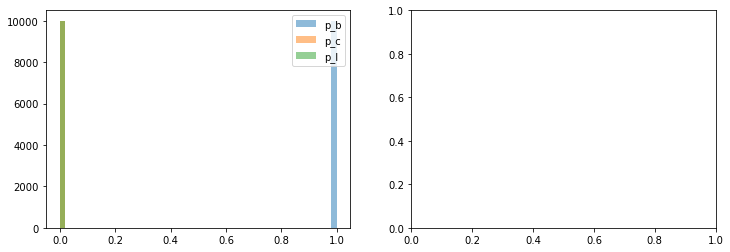

In [48]:
plot_prob_score_from_model(b_jets[0], 2, DL1_model)